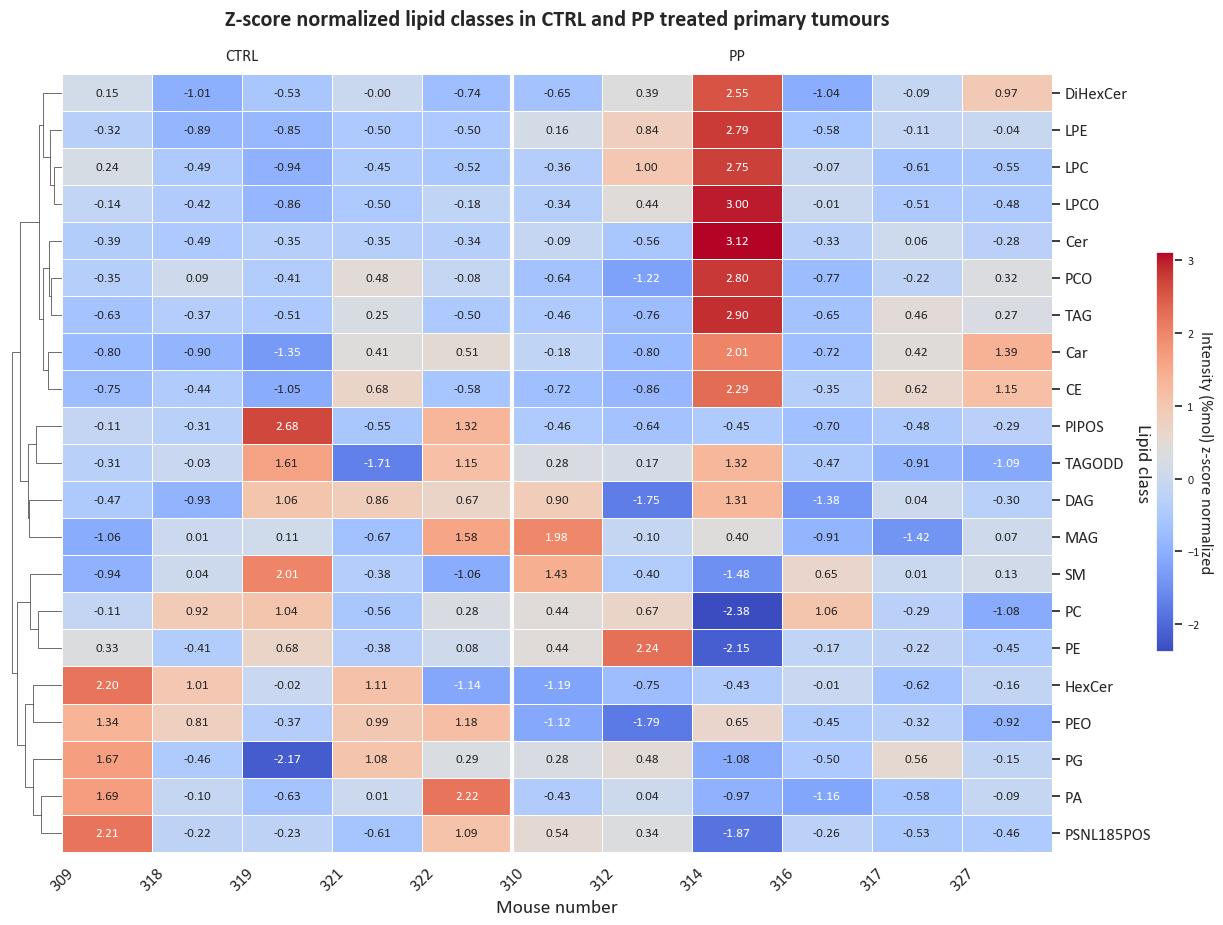

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import zscore
import matplotlib.colors as mcolors

# Set font globally
plt.rcParams['font.family'] = 'Calibri'

# Load data
lipids = pd.read_excel('Lipids mol%.xlsx')

# Prepare DataFrame
df = lipids.set_index("Lipid class")
df.columns = pd.MultiIndex.from_tuples(
    [(col.split("_")[0], col.split("_")[1]) for col in df.columns],
    names=["Group", "Mouse"]
)
df = df.loc[:, df.columns.get_level_values("Mouse") != "311"]
df_z = df.apply(zscore, axis=1)

# Separate groups
group_labels = df.columns.get_level_values("Group")
mouse_labels = df.columns.get_level_values("Mouse")
df_ctrl = df_z.loc[:, group_labels == "CTRL"]
df_pp = df_z.loc[:, group_labels == "PP"]
df_clustered = pd.concat([df_ctrl, df_pp], axis=1)

# Create clustermap (no colorbar)
g = sns.clustermap(
    df_clustered,
    cmap='coolwarm',
    linewidths=0.5,
    linecolor="white",
    figsize=(12, 10),
    cbar=False,
    row_cluster=True,
    col_cluster=False,
    annot=True,
    fmt=".2f",
    dendrogram_ratio=(0.05, 0.01),  # Wąski dendrogram
)

# Remove all unnecessary axes
for ax in g.fig.axes:
    if ax not in [g.ax_heatmap, g.ax_row_dendrogram]:
        g.fig.delaxes(ax)

# Manual colorbar
norm = mcolors.Normalize(vmin=df_clustered.min().min(), vmax=df_clustered.max().max())
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])

# Add colorbar to the right — farther from the heatmap
cbar_ax = g.fig.add_axes([0.967, 0.4, 0.015, 0.4])  # zwiększone "left"
cbar = g.fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Intensity (%mol) z-score normalized", fontsize=12, rotation=270, labelpad=10)
cbar.ax.yaxis.set_label_position('right')

# Add vertical separator
g.ax_heatmap.axvline(x=df_ctrl.shape[1], color='white', linewidth=3)

# Fix x-ticks
g.ax_heatmap.set_xticks(range(len(mouse_labels)))
g.ax_heatmap.set_xticklabels(mouse_labels, rotation=45, fontsize=12)

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=12)

# Group labels under plot
ctrl_center = (df_ctrl.shape[1] - 1) / 2
pp_center = df_ctrl.shape[1] + (df_pp.shape[1] - 1) / 2
g.ax_heatmap.text(ctrl_center, -0.7, "CTRL", ha='center', va='top', fontsize=12, transform=g.ax_heatmap.transData)
g.ax_heatmap.text(pp_center, -0.7, "PP", ha='center', va='top', fontsize=12, transform=g.ax_heatmap.transData)

# Title and labels
g.ax_heatmap.set_title("Z-score normalized lipid classes in CTRL and PP treated primary tumours", fontsize=16,fontweight='bold', pad=35)
g.ax_heatmap.set_xlabel("Mouse number", fontsize=14)
g.ax_heatmap.set_ylabel("Lipid class", rotation=270, labelpad=-0.5, fontsize=14)

# Adjust margins to fit everything
g.fig.subplots_adjust(bottom=0.2, right=0.88)

#plt.savefig("Clustermap_lipids_PT_no311.png", dpi=300, bbox_inches="tight")
plt.show()
